***Connecting the Spotify API***

In [1]:
import requests
import base64

# Replace with your own Client ID and Client Secret
CLIENT_ID = ''
CLIENT_SECRET = ''

# Base64 encode the client ID and client secret
client_credentials = f"{CLIENT_ID}:{CLIENT_SECRET}"
client_credentials_base64 = base64.b64encode(client_credentials.encode())

# Request the access token
token_url = 'https://accounts.spotify.com/api/token'
headers = {
    'Authorization': f'Basic {client_credentials_base64.decode()}'
}
data = {
    'grant_type': 'client_credentials'
}
response = requests.post(token_url, data=data, headers=headers)

if response.status_code == 200:
    access_token = response.json()['access_token']
    print("Access token obtained successfully.")
else:
    print("Error obtaining access token.")
    exit()

Access token obtained successfully.


In [6]:
! pip install spotipy

  Obtaining dependency information for spotipy from https://files.pythonhosted.org/packages/ea/35/304e456a471128aa4a776243558f43aee3444731ef8fc9bc8c351fddfdd8/spotipy-2.24.0-py3-none-any.whl.metadata
  Obtaining dependency information for redis>=3.5.3 from https://files.pythonhosted.org/packages/12/f5/ffa560ecc4bafbf25f7961c3d6f50d627a90186352e27e7d0ba5b1f6d87d/redis-5.2.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/261.4 kB ? eta -:--:--
   ---------------------------------------  256.0/261.4 kB 7.9 MB/s eta 0:00:01
   ---------------------------------------- 261.4/261.4 kB 8.1 MB/s eta 0:00:00


***Creating the Data Frame of the playlist***

In [8]:
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyOAuth

def get_trending_playlist_data(playlist_id, access_token):
    # Set up Spotipy with the access token
    sp = spotipy.Spotify(auth=access_token)

    # Get the tracks from the playlist
    playlist_tracks = sp.playlist_tracks(playlist_id, fields='items(track(id, name, artists, album(id, name)))')
    
     # Extract relevant information and store in a list of dictionaries
    music_data = []
    for track_info in playlist_tracks['items']:
        track = track_info['track']
        track_name = track['name']
        artists = ', '.join([artist['name'] for artist in track['artists']])
        album_name = track['album']['name']
        album_id = track['album']['id']
        track_id = track['id']

        # Get audio features for the track
        audio_features = sp.audio_features(track_id)[0] if track_id != 'Not available' else None

        # Get release date of the album
        try:
            album_info = sp.album(album_id) if album_id != 'Not available' else None
            release_date = album_info['release_date'] if album_info else None
        except:
            release_date = None

        # Get popularity of the track
        try:
            track_info = sp.track(track_id) if track_id != 'Not available' else None
            popularity = track_info['popularity'] if track_info else None
        except:
            popularity = None

     # Add additional track information to the track data
        track_data = {
            'Track Name': track_name,
            'Artists': artists,
            'Album Name': album_name,
            'Album ID': album_id,
            'Track ID': track_id,
            'Popularity': popularity,
            'Release Date': release_date,
            'Duration (ms)': audio_features['duration_ms'] if audio_features else None,
            'Explicit': track_info.get('explicit', None),
            'External URLs': track_info.get('external_urls', {}).get('spotify', None),
            'Danceability': audio_features['danceability'] if audio_features else None,
            'Energy': audio_features['energy'] if audio_features else None,
            'Key': audio_features['key'] if audio_features else None,
            'Loudness': audio_features['loudness'] if audio_features else None,
            'Mode': audio_features['mode'] if audio_features else None,
            'Speechiness': audio_features['speechiness'] if audio_features else None,
            'Acousticness': audio_features['acousticness'] if audio_features else None,
            'Instrumentalness': audio_features['instrumentalness'] if audio_features else None,
            'Liveness': audio_features['liveness'] if audio_features else None,
            'Valence': audio_features['valence'] if audio_features else None,
            'Tempo': audio_features['tempo'] if audio_features else None,
            # Add more attributes as needed
        }

        music_data.append(track_data)
        # Create a pandas DataFrame from the list of dictionaries
    df = pd.DataFrame(music_data)

    return df


***Accessing the Playlist***

In [50]:
playlist_id = '5ABHKGoOzxkaa28ttQV9sE' #That's the top 100 popular songs on Spotify

# Call the function to get the music data from the playlist and store it in a DataFrame
music_df = get_trending_playlist_data(playlist_id, access_token)

# Display the DataFrame
print(music_df)

                                       Track Name                     Artists  \
0                                 Blinding Lights                  The Weeknd   
1                                    Shape of You                  Ed Sheeran   
2                               Someone You Loved               Lewis Capaldi   
3                                       As It Was                Harry Styles   
4   Sunflower - Spider-Man: Into the Spider-Verse       Post Malone, Swae Lee   
..                                            ...                         ...   
95                           Too Good At Goodbyes                   Sam Smith   
96                                   Stay With Me                   Sam Smith   
97                                    Daydreaming                     Bruklin   
98                                      Kill Bill                         SZA   
99                      Havana (feat. Young Thug)  Camila Cabello, Young Thug   

                           

***Checking for Null Values***

In [51]:
print(music_df.isnull().sum())

Track Name          0
Artists             0
Album Name          0
Album ID            0
Track ID            0
Popularity          0
Release Date        0
Duration (ms)       0
Explicit            0
External URLs       0
Danceability        0
Energy              0
Key                 0
Loudness            0
Mode                0
Speechiness         0
Acousticness        0
Instrumentalness    0
Liveness            0
Valence             0
Tempo               0
dtype: int64


***Importing Files***

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

data = music_df

***Scaling the Features of the Track***

In [53]:
# Normalize the music features using Min-Max scaling
scaler = MinMaxScaler()
music_features = music_df[['Danceability', 'Energy', 'Key', 
                           'Loudness', 'Mode', 'Speechiness', 'Acousticness',
                           'Instrumentalness', 'Liveness', 'Valence', 'Tempo']].values
music_features_scaled = scaler.fit_transform(music_features)

***# Step 2: k-Nearest Neighbors for Content-Based Similarity***

In [54]:
# Step 2: k-Nearest Neighbors for Content-Based Similarity
knn = NearestNeighbors(n_neighbors=10, metric='cosine')
knn.fit(music_features_scaled)

def get_knn_recommendations(song_index, k=5):
    distances, indices = knn.kneighbors([music_features_scaled[song_index]], n_neighbors=k+1)
    similar_indices = indices.flatten()[1:]  # Exclude the input song itself
    return data.iloc[similar_indices]


In [55]:
kmeans = KMeans(n_clusters=5)  # Adjust the number of clusters as needed
data['cluster'] = kmeans.fit_predict(music_features_scaled)

C:\Users\kunal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kunal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


***# Step 3: k-Clustering Neighbors for Content-Based Similarity with cosine factors***

In [56]:
def get_cluster_recommendations(song_index, k=5):
    song_cluster = data.loc[song_index, 'cluster']
    cluster_songs = data[data['cluster'] == song_cluster]
    cluster_songs = cluster_songs[cluster_songs.index != song_index]

    # Optionally rank by cosine similarity within the cluster
    song_vector = music_features_scaled[song_index].reshape(1, -1)
    cluster_vectors = music_features_scaled[cluster_songs.index]
    similarities = cosine_similarity(song_vector, cluster_vectors).flatten()
    similar_indices = cluster_songs.index[np.argsort(-similarities)[:k]]
    return data.loc[similar_indices]


***Plotting Similarity Graph***

In [78]:
# Define the list of features to use in the radar plot
features = ['Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo']

def plot_feature_similarity(input_song_index, recommendations):
    # Extract features for the input song
    input_song_features = music_features_scaled[input_song_index]

    # Set up the radar plot configuration
    num_vars = len(features)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle

    for idx, rec_song_index in enumerate(recommendations.index):
        fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

        # Recommended song features
        rec_song_features = music_features_scaled[rec_song_index]

        # Prepare values for plotting with the correct length
        input_values = np.append(input_song_features, input_song_features[0])  # Adds first value at the end
        rec_values = np.append(rec_song_features, rec_song_features[0])  # Adds first value at the end

        # Plot input song features
        ax.plot(angles, input_values, linewidth=2, linestyle='solid', label='Input Song')
        ax.fill(angles, input_values, color='blue', alpha=0.25)

        # Plot recommended song features
        ax.plot(angles, rec_values, linewidth=2, linestyle='solid', label=f"Recommended Song {idx + 1}")
        ax.fill(angles, rec_values, color='orange', alpha=0.25)

        # Add labels and title
        ax.set_yticklabels([])
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(features)
        plt.title(f"Feature Comparison: Input Song vs Recommended Song {idx + 1}")
        plt.legend(loc='upper right')
        plt.show()


***Function for Recommendatioin***

In [79]:
def get_recommendations(song_name, k=5):
    # Adjust the column name here
    song_index = data[data['Track Name'] == song_name].index[0]

    knn_recs = get_knn_recommendations(song_index, k)
    cluster_recs = get_cluster_recommendations(song_index, k)

    print("k-NN Recommendations:")
    print(knn_recs[['Track Name', 'Artists']])

    print("\nCluster-Based Recommendations:")
    print(cluster_recs[['Track Name', 'Artists']])


***Test***

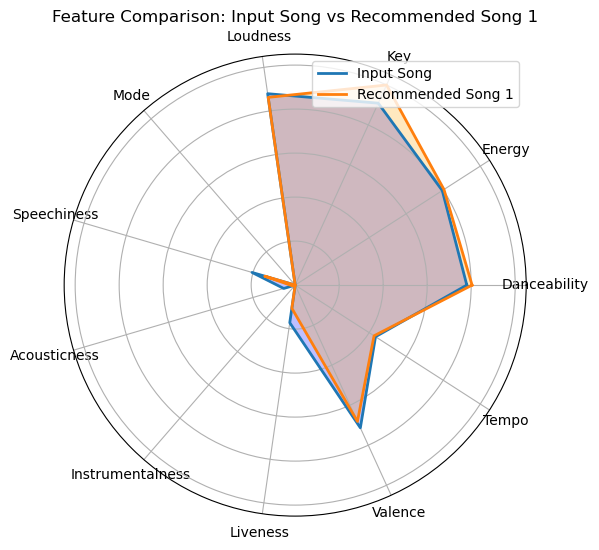

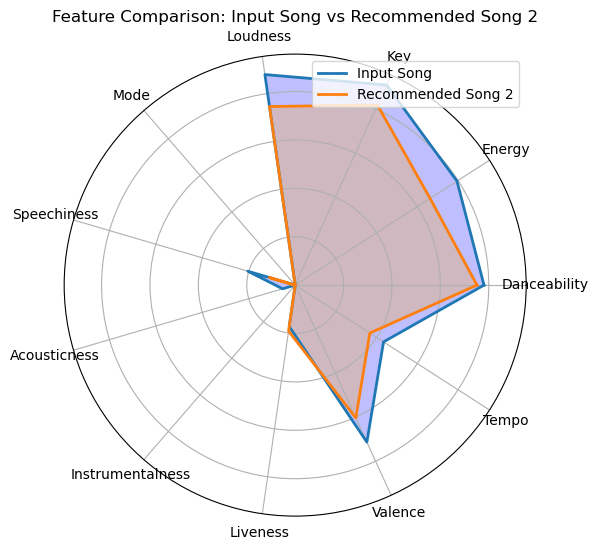

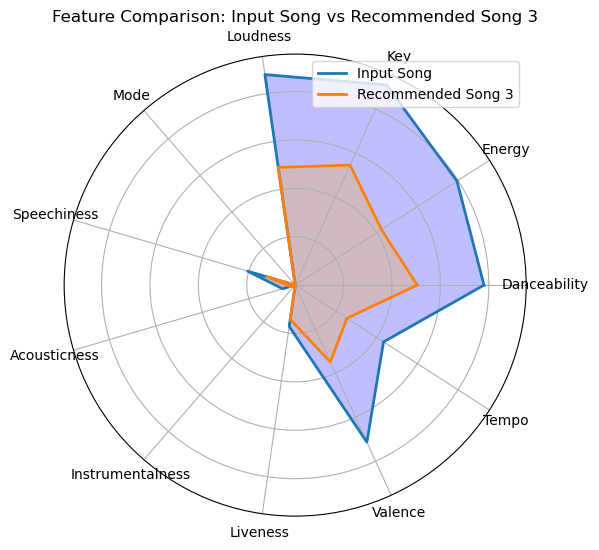

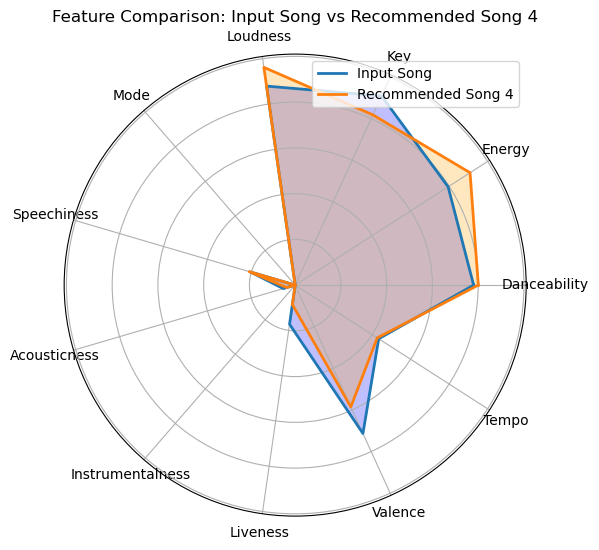

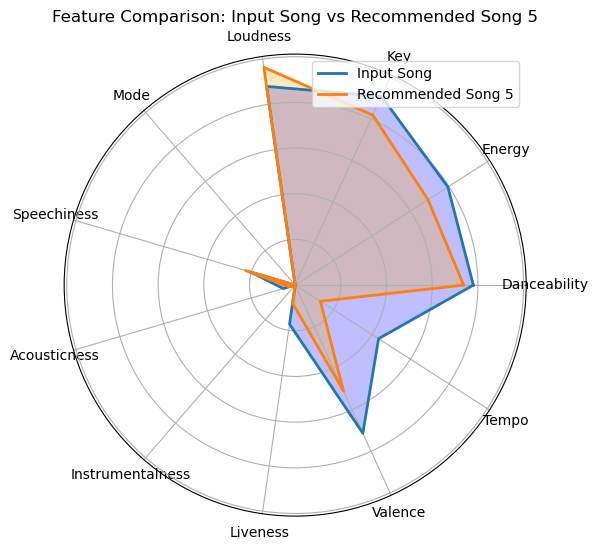

In [82]:
# Get the index of the input song
input_song_name = "Believer"
song_index = music_df[music_df['Track Name'] == input_song_name].index[0]

# Get recommendations using the k-NN approach
recommendations = get_knn_recommendations(song_index, k=5)

# Plot feature similarity between the input song and each recommended song
plot_feature_similarity(song_index, recommendations)

In [83]:
get_recommendations("Believer", k=5)


k-NN Recommendations:
                  Track Name                  Artists
24           Don't Start Now                 Dua Lipa
88                 New Rules                 Dua Lipa
94                     Vybez     Mj Grizz, Tory Lanez
71  One Kiss (with Dua Lipa)  Calvin Harris, Dua Lipa
97               Daydreaming                  Bruklin

Cluster-Based Recommendations:
                         Track Name                  Artists
24                  Don't Start Now                 Dua Lipa
88                        New Rules                 Dua Lipa
71         One Kiss (with Dua Lipa)  Calvin Harris, Dua Lipa
97                      Daydreaming                  Bruklin
90  There's Nothing Holdin' Me Back             Shawn Mendes
